# How to return state before hitting recursion limit

[Setting the graph recursion limit](https://langchain-ai.github.io/langgraph/how-tos/recursion-limit/) can help you control how long your graph will stay running, but if the recursion limit is hit your graph returns an error - which may not be ideal for all use cases. Instead you may wish to return the value of the state *just before* the recursion limit is hit. This how-to will show you how to do this.

## Setup

First, let's installed the required packages:

In [ ]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Without returning state

We are going to define a dummy graph in this example that will always hit the recursion limit. First, we will implement it without returning the state and show that it hits the recursion limit. This graph is based on the ReACT architecture, but instead of actually making decisions and taking actions it just loops forever.

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph import START, END

class State(TypedDict):
    value: str
    action_result: str

def router(state: State):
    if state['value'] == "end":
        return "__end__"
    else:
        return "action"

def decision_node(state):
    return {'value':'keep going!'}

def action_node(state: State):
    # Do your action here ...
    return {'action_result':'what a great result!'}

workflow = StateGraph(State)
workflow.add_node('decision',decision_node)
workflow.add_node('action',action_node)
workflow.add_edge(START,'decision')
workflow.add_conditional_edges('decision',router)
workflow.add_edge('action','decision')
app = workflow.compile()

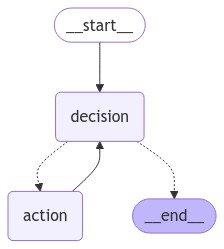

In [4]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

Let's verify that our graph will always hit the recursion limit:

In [9]:
from langgraph.errors import GraphRecursionError

try:
    app.invoke({"value":"hi!"})
except GraphRecursionError:
    print("Recursion Error")

Recursion Error


## With returning state

If we wanted to actually return the state, what we are going to do is introduce a new key to our state called `is_last_step` which keeps track of if we are on the last step of our recursion limit. If so, we will bypass all other graph decisions and simply terminate the graph, returning the state to the user without causing an error.

We are going to use a `ManagedValue` channel to do this. A `ManagedValue` channel is a state channel that will exist for the duration of our graph run and no longer. Since our `action` node is going to always induce at least 2 extra steps to our graph (since the `action` node ALWAYS calls the `decision` node afterwards), we will use this channel to check if we are within 2 steps of the limit. See the implementation of `IsLastOrSecondToLastStepManager` below.

This implementation very closely mirrors the implementation of `isLastStep` (which you can use by calling `from langgraph.managed import IsLastStep` and then decorating state keys with the `isLastStep` type), but in this case we check if we are on the last OR second-to-last step, instead of just the last step.

Now, when we run our graph we should receive no errors and instead get the last value of the state before the recursion limit was hit.

In [23]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from typing import Annotated

from langgraph.managed.base import ManagedValue


class IsLastOrSecondToLastStepManager(ManagedValue[bool]):
    def __call__(self, step: int) -> bool:
        limit = self.config.get("recursion_limit", 0)
        return step >= limit - 2
    
class State(TypedDict):
    value: str
    action_result: str
    is_last_step: Annotated[bool, IsLastOrSecondToLastStepManager]

def router(state: State):
    # Force the agent to end if it is on the last step
    if state['is_last_step']:
        return "__end__"
    if state['value'] == "end":
        return "__end__"
    else:
        return "action"

def decision_node(state):
    return {'value':'keep going!'}

def action_node(state: State):
    # Do your action here ...
    return {'action_result':'what a great result!'}

workflow = StateGraph(State)
workflow.add_node('decision',decision_node)
workflow.add_node('action',action_node)
workflow.add_edge(START,'decision')
workflow.add_conditional_edges('decision',router)
workflow.add_edge('action','decision')
app = workflow.compile()

In [25]:
app.invoke({"value":"hi!"})

{'value': 'keep going!', 'action_result': 'what a great result!'}

Perfect! Our code ran with no error, just as we expected!